# Assess Feature Importance
See what the most-important features in our model are

In [1]:
from matplotlib import pyplot as plt
import pickle as pkl
import pandas as pd
import numpy as np

## Load in the Model, Featurizer, and Data
Get the model from disk, which we'll use to get the selected features, and the featurizer which we'll use to get feature names.

We also need the data to assess the influence of the figures on the 

In [2]:
with open('best_model.pkl', 'rb') as fp:
    model = pkl.load(fp).best_estimator_  # Go ahead and get the best model out of the GridSearchCV

In [3]:
with open('../featurizers.pkl', 'rb') as fp:
    featurizer = pkl.load(fp)

In [4]:
with open('../al_starting_frame.pkl', 'rb') as fp:
    atoms = pkl.load(fp)

In [5]:
data = pd.read_pickle('data/random_data.pkl.gz').query('not initial')

In [6]:
data['charge density at t=0.00']

21321   -3.539587
21322   -3.538461
21323   -3.537322
21324   -3.536171
21325   -3.535010
           ...   
30695   -3.515691
30696   -3.514837
30697   -3.513993
30698   -3.513160
30699   -3.512337
Name: charge density at t=0.00, Length: 9379, dtype: float64

## Get the Names of the Selected Features
There are two processes we need to pass the feature names through: going from base features to polynomial expansion, and from polynomial expansion to LASSO-selected features

In [7]:
features = featurizer.feature_labels()
print(f'Starting with {len(features)} initial features: {", ".join(features[:3])}, ...')

Starting with 18 initial features: charge density at t=-4.00, charge density at t=-3.00, charge density at t=-2.00, ...


Get the polynomial features

In [8]:
expander = model.steps[0][1]

In [9]:
expanded_features = expander.get_feature_names(features)
print(f'Got a set of {len(expanded_features)} polynomial features')

Got a set of 189 polynomial features


Get the ones that were selected

In [10]:
selector = model.steps[1][1]
selected_features = np.array(expanded_features)[selector.get_support()]

In [11]:
print(f'Selected down to {len(selected_features)} features by first LASSO pass')

Selected down to 25 features by first LASSO pass


Get the ones that are most important from the bayesian model

In [12]:
lr = model.steps[-1][1]

In [13]:
feature_by_coefs = pd.DataFrame({'name': selected_features, 'coef': lr.coef_})

In [14]:
feature_by_coefs['coef_mag'] = feature_by_coefs['coef'].abs()

In [15]:
feature_by_coefs.sort_values('coef_mag', ascending=False)

,name,coef,coef_mag
17,charge density at t=0.00 AGNI projected eta=1....,3.265077,3.265077
20,charge density at t=0.00 AGNI projected eta=1....,1.486059,1.486059
12,charge density at t=-2.00 AGNI projected eta=1...,-0.954772,0.954772
3,AGNI projected eta=1.23e+00,0.304534,0.304534
19,charge density at t=0.00 AGNI projected eta=2....,-0.253301,0.253301
4,ion-ion repulsion,0.200313,0.200313
18,charge density at t=0.00 AGNI projected eta=1....,0.186531,0.186531
21,charge density at t=0.00 ion-ion repulsion,0.166924,0.166924
10,charge density at t=-3.00 AGNI projected eta=1...,0.133569,0.133569
22,charge density at t=0.50 AGNI projected eta=8....,-0.032593,0.032593


**TODO**: Make a plot where we group the importance of charge density features where I group them by their time relative to present. May have to train a separate model where we do not use polynomial features and feature selection. The goal is to verify that importance decreases as you get farther from the present position.

Coefficients must be normalized to be useful and we trained our model without normalization. Interpreting these directly wouldn't be particularly useful.

In [16]:
feature_by_coefs['name'].tolist()

['charge density at t=0.50',
 'charge density at t=1.00',
 'charge density at t=2.00',
 'AGNI projected eta=1.23e+00',
 'ion-ion repulsion',
 'charge density at t=-4.00^2',
 'charge density at t=-4.00 charge density at t=2.00',
 'charge density at t=-4.00 AGNI projected eta=1.23e+00',
 'charge density at t=-3.00 charge density at t=-1.00',
 'charge density at t=-3.00 charge density at t=2.00',
 'charge density at t=-3.00 AGNI projected eta=1.23e+00',
 'charge density at t=-2.00 charge density at t=1.00',
 'charge density at t=-2.00 AGNI projected eta=1.23e+00',
 'charge density at t=-2.00 ion-ion repulsion',
 'charge density at t=-1.00 charge density at t=-0.50',
 'charge density at t=-0.50 ion-ion repulsion',
 'charge density at t=0.00 charge density at t=0.50',
 'charge density at t=0.00 AGNI projected eta=1.23e+00',
 'charge density at t=0.00 AGNI projected eta=1.88e+00',
 'charge density at t=0.00 AGNI projected eta=2.89e+00',
 'charge density at t=0.00 AGNI projected eta=1.60e+01'

Ignoring the coefficients, we see at least a few key categories:
1. Ion-ion repulsion. Things that include the Coulomb repulsion
2. Charge density ahead. Dealing with the charge density ahead of the projectile
3. Charge density behind

In [17]:
feature_by_coefs['category'] = 'other'

In [18]:
feature_by_coefs.loc[feature_by_coefs.name.str.contains('AGNI'), 'category'] = 'atomic'

In [19]:
feature_by_coefs.loc[feature_by_coefs.name.str.contains('charge density at t='), 'category'] = 'ahead'

In [20]:
feature_by_coefs.loc[feature_by_coefs.name.str.contains('t=-'), 'category'] = 'behind'

In [21]:
feature_by_coefs.loc[feature_by_coefs.name.str.contains('ion-ion'), 'category'] = 'coulomb'

In [22]:
feature_by_coefs[['name', 'category']]

,name,category
0,charge density at t=0.50,ahead
1,charge density at t=1.00,ahead
2,charge density at t=2.00,ahead
3,AGNI projected eta=1.23e+00,atomic
4,ion-ion repulsion,coulomb
5,charge density at t=-4.00^2,behind
6,charge density at t=-4.00 charge density at t=...,behind
7,charge density at t=-4.00 AGNI projected eta=1...,behind
8,charge density at t=-3.00 charge density at t=...,behind
9,charge density at t=-3.00 charge density at t=...,behind


## Get the influence on predictions
We are going to study the importance of features by assessing their impact on the force outcome as a function of position 

In [23]:
X = data[featurizer.feature_labels()]

Expand then select them

In [24]:
X_inputs = selector.transform(expander.transform(X))

We can now get the contribution of each point to the force prediction

In [25]:
contributions = np.multiply(X_inputs, lr.coef_)  # The coefficients work with unnormalized values
contributions = pd.DataFrame(contributions, columns=selected_features)

Get the single features with the most prominent contribution at each stage

In [26]:
most_influential = contributions.abs().idxmax(axis=1)
print(f'Only {len(set(most_influential))} features are ever the most important')
set(most_influential)

Only 6 features are ever the most important


{'charge density at t=-1.00 charge density at t=-0.50',
 'charge density at t=-3.00 charge density at t=-1.00',
 'charge density at t=0.00 charge density at t=0.50',
 'charge density at t=0.00 ion-ion repulsion',
 'charge density at t=2.00',
 'ion-ion repulsion'}

Grouping by category

In [27]:
contrib_by_category = {}
for gid, group in feature_by_coefs.groupby('category'):
    contrib_by_category[gid] = contributions[group['name']].sum(axis=1).values
contrib_by_category = pd.DataFrame(contrib_by_category)

In [28]:
contrib_by_category.abs().idxmax(axis=1).value_counts() / len(contrib_by_category)

ahead      0.651136
coulomb    0.188400
behind     0.160465
dtype: float64

The atomic features are generally the most important followed by the amorphous "other"

Plot which is dominant in different regions

In [29]:
relative_contribution = np.divide(contrib_by_category.abs(), contrib_by_category.abs().sum(axis=1).values[:, None])
relative_contribution['largest'] = contrib_by_category.abs().idxmax(axis=1)

In [30]:
relative_contribution.describe() * 100

,ahead,atomic,behind,coulomb
count,937900.000000,937900.000000,937900.000000,937900.000000
mean,44.649033,0.418276,24.924974,30.007717
std,17.073201,0.475781,15.215292,15.852081
min,0.069275,0.000053,0.008079,0.018625
25%,33.792435,0.108055,12.550998,18.957468
50%,55.339427,0.279834,21.613096,29.401102
75%,56.561252,0.561426,39.128841,42.050774
max,92.150121,4.079392,76.333957,97.938940


In [31]:
relative_contribution['timestep'] = data['timestep'].values
relative_contribution['displacement'] = data['displacement'].values

We see that the atomic changes never contribute more than 4% of the total force prediction.

In [32]:
change_points = relative_contribution[(relative_contribution.largest != relative_contribution.shift(1).largest) | (relative_contribution.largest != relative_contribution.shift(-1).largest)]

In [33]:
atoms.get_all_distances(mic=True)[:, 0].mean()

14.8857779054189

In [34]:
def find_closest_atom(position) -> float:
    """Find the distance to the closest atoms"""
    
    # Move the projectile
    atoms.positions[-1, :] = position
    
    # Compute the distances to this atom
    return atoms.get_distances(-1, slice(0, -1), mic=True).min()

In [35]:
data['distance_to_atom'] = data['position'].apply(find_closest_atom)

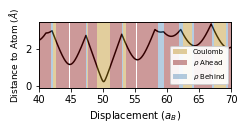

In [36]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

# Colors for each type
colors = {
    'coulomb': 'darkgoldenrod',
    'ahead': 'maroon',
    'behind': 'steelblue'
}

# Plot the regions where different features dominate
ax2 = ax.twinx()
ax2.set_ylim([0, 1])
widths = change_points.displacement.diff()[1::2].values
labels = change_points.largest[::2].values
starts = change_points.displacement[::2].values
for label, color in colors.items():
    label_text = label.capitalize()
    if label_text != "Coulomb":
        label_text = "$\\rho$ " + label_text
    ax2.fill_between(data.displacement, 0, 1, where=relative_contribution.largest == label,
                     color=color, alpha=0.4, label=label_text, lw=0)
    

# Plot the force for a background
ax.plot(data.displacement, data['distance_to_atom'].values, color='k', lw=1.5)
#ax.set_yscale('symlog')
ax.set_ylabel('Distance to Atom ($\\AA$)', fontsize=9)
ax.set_ylim(-0.1, 3.5)
#ax.set_yticklabels([])
    
ax2.legend(ncol=1, fontsize=7, loc='lower right', framealpha=0.9)
ax2.set_yticks([])

# Plot only a major region
ax.set_xlim(40, 70)
ax.set_xlabel('Displacement ($a_B$)')

fig.tight_layout()
fig.savefig('figures/dominant-features-vs-distance.png', dpi=320)
fig.savefig('figures/dominant-features-vs-distance.pdf')

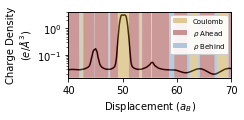

In [37]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

# Colors for each type
colors = {
    'coulomb': 'darkgoldenrod',
    'ahead': 'maroon',
    'behind': 'steelblue'
}

# Plot the regions where different features dominate
ax2 = ax.twinx()
ax2.set_ylim([0, 1])
widths = change_points.displacement.diff()[1::2].values
labels = change_points.largest[::2].values
starts = change_points.displacement[::2].values
for label, color in colors.items():
    label_text = label.capitalize()
    if label_text != "Coulomb":
        label_text = "$\\rho$ " + label_text
    ax2.fill_between(data.displacement, 0, 1, where=relative_contribution.largest == label,
                     color=color, alpha=0.4, label=label_text, lw=0, interpolate=True)
    

# Plot the force for a background
ax.plot(data.displacement, np.exp(data['charge density at t=0.00'].values), color='k', lw=1.5)
ax.set_yscale('log')
ax.set_ylabel('Charge Density\n($e / \\AA^3$)')
#ax.set_yticklabels([])
    
ax2.legend(ncol=1, fontsize=7, loc='upper right', framealpha=0.9)
ax2.set_yticks([])

# Plot only a major region
ax.set_xlim(40, 70)
ax.set_xlabel('Displacement ($a_B$)')

fig.tight_layout()
fig.savefig('figures/dominant-features-vs-density.png', dpi=320)
fig.savefig('figures/dominant-features-vs-density.pdf')

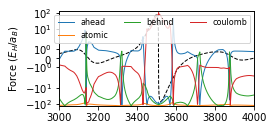

In [38]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

# Plot the force for a background
ax.plot(data.timestep, data['force'].values, 'k--', lw=1.)
ax.set_yscale('symlog')
ax.set_ylabel('Force ($E_H/a_B$)')

# Plot the regions where different features dominate
ax2 = ax.twinx()
ax2.set_ylim([0, 1])
for c in relative_contribution.columns[:4]:
    ax2.plot(relative_contribution.timestep, relative_contribution[c], label=c, lw=1)
    
ax2.legend(ncol=3, fontsize=8)
ax2.set_yticks([])

# Plot only a major region
ax.set_xlim(3000, 4000)

fig.savefig('figures/dominant-features-line.png', dpi=320)

Let's see how they change over time

**TODO**: Quantify the correlation between different feature sets. Specifically, are the "before" features strongly correlated with the "coulomb"
- Longer-term: Assess the feature importance using an "ablation" technique